In [ ]:
# ⚠️ Important: Set JAX to use CPU (must be set before importing JAX)
import os
import sys
from pathlib import Path

# Add project root to Python path
# Find project root by looking for infodynamics_jax directory
current_dir = Path.cwd()
project_root = None
# Try current directory and parent directories
for path in [current_dir, current_dir.parent, current_dir.parent.parent]:
    if (path / 'infodynamics_jax').exists() and (path / 'infodynamics_jax' / '__init__.py').exists():
        project_root = path
        break

if project_root is None:
    # Fallback: assume we're in examples/ and project root is one level up
    project_root = current_dir.parent if current_dir.name == 'examples' else current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

os.environ['JAX_PLATFORM_NAME'] = 'cpu'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# Import necessary modules
from __future__ import annotations

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_default_prng_impl', 'rbg')

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any

print(f"Project root: {project_root}")
print(f"Python path includes project root: {str(project_root) in sys.path}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print("✅ JAX setup complete!")

JAX version: 0.8.2
Metal device set to: Apple M4
JAX devices: [CpuDevice(id=0)]
✅ JAX setup complete!


W0000 00:00:1768243987.401574 13994315 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1768243987.418798 13994315 service.cc:145] XLA service 0x11cf96fb0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768243987.418809 13994315 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1768243987.420187 13994315 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1768243987.420222 13994315 mps_client.cc:384] XLA backend will use up to 11452776448 bytes on device 0 for SimpleAllocator.


In [ ]:
# Import our library
from infodynamics_jax.core import Phi
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.kernels.rbf import rbf as rbf_kernel
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.inference.optimisation import MAP2, MAP2CFG
from infodynamics_jax.infodynamics import run, RunCFG
from infodynamics_jax.infodynamics.hyperprior import kernel_log_l2_hyperprior

print("✅ Successfully imported all modules!")

✅ Successfully imported all modules!


## 1. Generate Regression Data

In [3]:
# Generate regression data
key = jax.random.key(42)

# Generate input X (1D)
N_train = 30
N_test = 100
X_train = jnp.linspace(-3, 3, N_train)[:, None]
X_test = jnp.linspace(-4, 4, N_test)[:, None]

# Generate true function (sine wave + linear trend)
true_func = lambda x: 2 * jnp.sin(2 * x[:, 0]) + 0.5 * x[:, 0]
f_train = true_func(X_train)
f_test = true_func(X_test)

# Add observation noise
key, subkey = jax.random.split(key)
noise_std = 0.3
Y_train = f_train + noise_std * jax.random.normal(subkey, (N_train,))

print(f"Training data: X={X_train.shape}, Y={Y_train.shape}")
print(f"Test data: X={X_test.shape}")
print(f"True noise std: {noise_std:.3f}")

Training data: X=(30, 1), Y=(30,)
Test data: X=(100, 1)
True noise std: 0.300


## 2. Initialize Model Parameters

In [4]:
# Initialize Phi (model parameters)
# Estimate initial lengthscale from data range
x_range = float(X_train[:, 0].max() - X_train[:, 0].min())
initial_lengthscale = jnp.array(x_range / 2.0)  # Half of data range
initial_variance = jnp.array(1.0)
initial_noise_var = jnp.array(0.1)

kernel_params = KernelParams(
    lengthscale=initial_lengthscale,
    variance=initial_variance,
)

# Create inducing points (using subset of X_train)
M = min(15, N_train)
Z = X_train[::max(1, N_train // M)].copy()

# Create initial Phi with larger jitter for numerical stability
phi_init = Phi(
    kernel_params=kernel_params,
    Z=Z,
    likelihood_params={"noise_var": initial_noise_var},
    jitter=1e-5,  # Larger jitter for stability
)

print(f"Number of inducing points: {M}")
print(f"Inducing points shape: {Z.shape}")
print(f"Kernel params - lengthscale: {phi_init.kernel_params.lengthscale:.3f}, variance: {phi_init.kernel_params.variance:.3f}")
print(f"Likelihood params - noise_var: {phi_init.likelihood_params['noise_var']:.3f}")

Number of inducing points: 15
Inducing points shape: (15, 1)
Kernel params - lengthscale: 3.000, variance: 1.000
Likelihood params - noise_var: 0.100


## 3. Create Energy Function

In [5]:
# Create InertialEnergy (data-dependent energy)
gaussian_likelihood = get_likelihood("gaussian")
inertial_cfg = InertialCFG(
    estimator="gh",  # Use Gauss-Hermite quadrature
    gh_n=20,
    inner_steps=0,  # No inner optimization
)
inertial_energy = InertialEnergy(
    kernel_fn=rbf_kernel,
    likelihood=gaussian_likelihood,
    cfg=inertial_cfg,
)

print("✅ InertialEnergy created successfully!")

✅ InertialEnergy created successfully!


## 4. Run ML-II Optimization (No Prior)

In [ ]:
# Configure MAP2 optimizer
map2_cfg = MAP2CFG(
    steps=300,
    lr=5e-3,
    optimizer="adam",
    clip_grad_norm=5.0,
    jit=False,  # Disable JIT for debugging
    constrain_params=True,
)

map2_method = MAP2(cfg=map2_cfg)

# Run ML-II (no hyperprior)
print("=" * 60)
print("ML-II Optimization (InertialEnergy only, no prior)")
print("=" * 60)

key, subkey = jax.random.split(key)
out_ml2 = run(
    key=subkey,
    method=map2_method,
    energy=inertial_energy,
    phi_init=phi_init,
    energy_args=(X_train, Y_train),
    cfg=RunCFG(jit=False),
)

result_ml2 = out_ml2.result
phi_ml2 = result_ml2.phi
energy_trace_ml2 = result_ml2.energy_trace

print(f"✅ ML-II optimization complete!")
print(f"Final energy: {energy_trace_ml2[-1]:.3f}")
print(f"Initial energy: {energy_trace_ml2[0]:.3f}")
print(f"Energy reduction: {energy_trace_ml2[0] - energy_trace_ml2[-1]:.3f}")
print(f"\nOptimized parameters:")
print(f"  - lengthscale: {phi_ml2.kernel_params.lengthscale:.3f}")
print(f"  - variance: {phi_ml2.kernel_params.variance:.3f}")
print(f"  - noise_var: {phi_ml2.likelihood_params['noise_var']:.3f}")
print(f"\nDiagnostics: {out_ml2.diagnostics}")

ML-II Optimization (InertialEnergy only, no prior)
✅ ML-II optimization complete!
Final energy: 160.335
Initial energy: 349.111
Energy reduction: 188.775

Optimized parameters:
  - lengthscale: 2.442 (finite: True)
  - variance: 0.206 (finite: True)
  - noise_var: 0.800 (finite: True)

Diagnostics: {'method': 'MAP2', 'final_energy': 160.33538818359375, 'initial_energy': 349.1107482910156, 'energy_change': 188.77536010742188, 'final_grad_norm': 5.0}


## 5. Run MAP-II Optimization (With Hyperprior)

In [ ]:
# Create hyperprior function
def hyperprior_fn(phi):
    """L2 hyperprior on log kernel parameters."""
    return kernel_log_l2_hyperprior(
        phi,
        fields=["lengthscale", "variance"],
        lam=0.1,  # Regularization strength
        mu={"lengthscale": 0.0, "variance": 0.0},  # Prior mean on log scale
    )

# Run MAP-II (with hyperprior)
print("=" * 60)
print("MAP-II Optimization (InertialEnergy + hyperprior)")
print("=" * 60)

key, subkey = jax.random.split(key)
out_map2 = run(
    key=subkey,
    method=map2_method,
    energy=inertial_energy,
    phi_init=phi_init,
    energy_args=(X_train, Y_train),
    hyperprior=hyperprior_fn,
    cfg=RunCFG(jit=False),
)

result_map2 = out_map2.result
phi_map2 = result_map2.phi
energy_trace_map2 = result_map2.energy_trace

print(f"✅ MAP-II optimization complete!")
print(f"Final energy: {energy_trace_map2[-1]:.3f}")
print(f"Initial energy: {energy_trace_map2[0]:.3f}")
print(f"Energy reduction: {energy_trace_map2[0] - energy_trace_map2[-1]:.3f}")
print(f"\nOptimized parameters:")
print(f"  - lengthscale: {phi_map2.kernel_params.lengthscale:.3f}")
print(f"  - variance: {phi_map2.kernel_params.variance:.3f}")
print(f"  - noise_var: {phi_map2.likelihood_params['noise_var']:.3f}")
print(f"\nDiagnostics: {out_map2.diagnostics}")

MAP-II Optimization (InertialEnergy + hyperprior)
✅ MAP-II optimization complete!
Final energy: 65.910
Initial energy: 349.171
Energy reduction: 283.261

Optimized parameters:
  - lengthscale: 2.673 (finite: True)
  - variance: 0.241 (finite: True)
  - noise_var: 0.898 (finite: True)

Diagnostics: {'method': 'MAP2', 'final_energy': 65.90985107421875, 'initial_energy': 349.17108154296875, 'energy_change': 283.26123046875, 'final_grad_norm': 5.0}


In [ ]:
import jax.scipy.linalg
from infodynamics_jax.gp.sparsify import SparsifiedKernel

def gp_predict_type2(phi, X_test, X_train, Y_train, kernel_fn, residual="fitc"):
    """
    Make GP predictions for type-II inference using sparsified kernel.
    
    This is the CORRECT way for type-II / collapsed VFE:
    - u is already marginalised in S_ff = Q + R
    - Directly compute predictive distribution under sparsified kernel
    - No q(u|phi) state is needed or constructed
    
    Returns:
        mu: mean predictions (N_test,) or (N_test, D)
        var: variance predictions (N_test,) or (N_test, D)
    """
    Y_train = Y_train[:, None] if Y_train.ndim == 1 else Y_train
    N_train, D = Y_train.shape
    N_test = X_test.shape[0]
    
    Z = phi.Z  # (M, Q)
    noise_var = phi.likelihood_params.get("noise_var", jnp.array(0.1))
    noise_var = jnp.asarray(noise_var)
    if noise_var.ndim == 0:
        noise_var = noise_var[None]
    noise_var = jnp.broadcast_to(noise_var, (D,))
    
    # Get sparsified kernel
    sk = SparsifiedKernel(kernel_fn=kernel_fn, residual=residual)
    
    # Compute sparsified kernel matrices
    # S_train_train: (N_train, N_train)
    S_train_train = sk.S_ff(phi.kernel_params, X_train, Z, jitter=phi.jitter)
    
    # S_test_train: (N_test, N_train) - cross-covariance
    K_test_Z = kernel_fn(X_test, Z, phi.kernel_params)  # (N_test, M)
    K_train_Z = kernel_fn(X_train, Z, phi.kernel_params)  # (N_train, M)
    K_ZZ = kernel_fn(Z, Z, phi.kernel_params)  # (M, M)
    K_ZZ = 0.5 * (K_ZZ + K_ZZ.T) + phi.jitter * jnp.eye(K_ZZ.shape[0], dtype=K_ZZ.dtype)
    
    # Q_test_train = K_test_Z @ K_ZZ^{-1} @ K_train_Z^T
    L_ZZ = jnp.linalg.cholesky(K_ZZ)
    A_test = jax.scipy.linalg.cho_solve((L_ZZ, True), K_test_Z.T).T  # (N_test, M)
    A_train = jax.scipy.linalg.cho_solve((L_ZZ, True), K_train_Z.T).T  # (N_train, M)
    Q_test_train = A_test @ A_train.T  # (N_test, N_train)
    
    # For FITC, cross-covariance uses Q only (residual is diagonal only)
    S_test_train = Q_test_train
    
    # S_test_test: (N_test, N_test) - test covariance (diagonal only)
    K_test_test_diag = jnp.diag(kernel_fn(X_test, X_test, phi.kernel_params))  # (N_test,)
    Q_test_test_diag = jnp.sum(A_test**2, axis=1)  # (N_test,)
    
    if residual.lower() == "fitc":
        R_test_diag = jnp.maximum(K_test_test_diag - Q_test_test_diag, 0.0)
        S_test_test_diag = Q_test_test_diag + R_test_diag
    else:
        S_test_test_diag = Q_test_test_diag
    
    # For each output dimension, compute predictive distribution
    def predict_for_dim(y_d, noise_var_d):
        """Compute prediction for single output dimension."""
        y_d = y_d[:, None]  # (N_train, 1)
        
        # Training posterior under sparsified kernel:
        # μ_train = S_train_train @ (S_train_train + σ²I)^{-1} y
        S_train_noise = S_train_train + noise_var_d * jnp.eye(N_train, dtype=S_train_train.dtype)
        L_train = jnp.linalg.cholesky(S_train_noise)
        
        # Predictive mean: μ_test = S_test_train @ (S_train_train + σ²I)^{-1} y
        mu_test = S_test_train @ jax.scipy.linalg.cho_solve((L_train, True), y_d)  # (N_test, 1)
        
        # Predictive variance:
        # var_test = S_test_test - S_test_train @ (S_train_train + σ²I)^{-1} @ S_test_train^T + σ²
        S_test_train_solve = jax.scipy.linalg.cho_solve((L_train, True), S_test_train.T)  # (N_train, N_test)
        var_f = S_test_test_diag - jnp.sum(S_test_train * S_test_train_solve.T, axis=1)  # (N_test,)
        var_f = jnp.maximum(var_f, 0.0)
        
        # Add observation noise
        var_pred = var_f + noise_var_d
        
        return mu_test[:, 0], var_pred  # (N_test,), (N_test,)
    
    # Compute for each output dimension
    if D == 1:
        mu, var = predict_for_dim(Y_train[:, 0], noise_var[0])
    else:
        mu_list = []
        var_list = []
        for d in range(D):
            mu_d, var_d = predict_for_dim(Y_train[:, d], noise_var[d])
            mu_list.append(mu_d)
            var_list.append(var_d)
        mu = jnp.stack(mu_list, axis=1)  # (N_test, D)
        var = jnp.stack(var_list, axis=1)  # (N_test, D)
    
    # Squeeze to 1D if needed
    mu = mu.squeeze()
    var = var.squeeze()
    
    return mu, var

# Make predictions for both methods using correct type-II prediction
mu_test_ml2, var_test_ml2 = gp_predict_type2(phi_ml2, X_test, X_train, Y_train, rbf_kernel)
mu_test_map2, var_test_map2 = gp_predict_type2(phi_map2, X_test, X_train, Y_train, rbf_kernel)

std_test_ml2 = jnp.sqrt(var_test_ml2)
std_test_map2 = jnp.sqrt(var_test_map2)

print("✅ Predictions computed for both methods using correct type-II approach!")

✅ Predictions computed for both methods!


## 7. Compute Metrics

In [9]:
def compute_metrics(y_true, y_pred, y_var=None):
    """
    Compute regression metrics.
    
    Returns:
        Dictionary of metrics
    """
    metrics = {}
    
    # Mean Squared Error
    mse = jnp.mean((y_true - y_pred) ** 2)
    metrics["MSE"] = float(mse)
    
    # Root Mean Squared Error
    rmse = jnp.sqrt(mse)
    metrics["RMSE"] = float(rmse)
    
    # Mean Absolute Error
    mae = jnp.mean(jnp.abs(y_true - y_pred))
    metrics["MAE"] = float(mae)
    
    # Mean Absolute Percentage Error
    mape = jnp.mean(jnp.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    metrics["MAPE"] = float(mape)
    
    # R-squared
    ss_res = jnp.sum((y_true - y_pred) ** 2)
    ss_tot = jnp.sum((y_true - jnp.mean(y_true)) ** 2)
    r2 = 1.0 - (ss_res / (ss_tot + 1e-8))
    metrics["R²"] = float(r2)
    
    # Log-likelihood (if variance is provided)
    if y_var is not None:
        # Log-likelihood under Gaussian predictive distribution
        log_lik = jnp.sum(
            -0.5 * jnp.log(2 * jnp.pi * y_var)
            - 0.5 * (y_true - y_pred) ** 2 / y_var
        )
        metrics["Log-Likelihood"] = float(log_lik)
        
        # Negative Log-Likelihood
        metrics["NLL"] = float(-log_lik)
        
        # Mean Log-Likelihood
        metrics["Mean Log-Likelihood"] = float(log_lik / len(y_true))
    
    return metrics

# Compute metrics for both methods
metrics_ml2 = compute_metrics(f_test, mu_test_ml2, var_test_ml2)
metrics_map2 = compute_metrics(f_test, mu_test_map2, var_test_map2)

print("\n" + "=" * 60)
print("Metrics Comparison")
print("=" * 60)
print(f"\n{'Metric':<20} {'ML-II':<15} {'MAP-II':<15}")
print("-" * 50)
for key in metrics_ml2.keys():
    print(f"{key:<20} {metrics_ml2[key]:<15.4f} {metrics_map2[key]:<15.4f}")

# Compute improvement
print("\n" + "=" * 60)
print("Improvement (MAP-II vs ML-II)")
print("=" * 60)
for key in metrics_ml2.keys():
    if key in ["R²", "Log-Likelihood", "Mean Log-Likelihood"]:
        # Higher is better
        improvement = ((metrics_map2[key] - metrics_ml2[key]) / abs(metrics_ml2[key] + 1e-8)) * 100
        print(f"{key:<20}: {improvement:+.2f}%")
    else:
        # Lower is better
        improvement = ((metrics_ml2[key] - metrics_map2[key]) / (metrics_ml2[key] + 1e-8)) * 100
        print(f"{key:<20}: {improvement:+.2f}%")


Metrics Comparison

Metric               ML-II           MAP-II         
--------------------------------------------------
MSE                  3.7603          3.7603         
RMSE                 1.9392          1.9392         
MAE                  1.5736          1.5736         
MAPE                 100.0000        100.0000       
R²                   0.0000          0.0000         
Log-Likelihood       -1411.3116      -1430.6284     
NLL                  1411.3116       1430.6284      
Mean Log-Likelihood  -14.1131        -14.3063       

Improvement (MAP-II vs ML-II)
MSE                 : +0.00%
RMSE                : +0.00%
MAE                 : +0.00%
MAPE                : +0.00%
R²                  : +0.00%
Log-Likelihood      : -1.37%
NLL                 : -1.37%
Mean Log-Likelihood : -1.37%


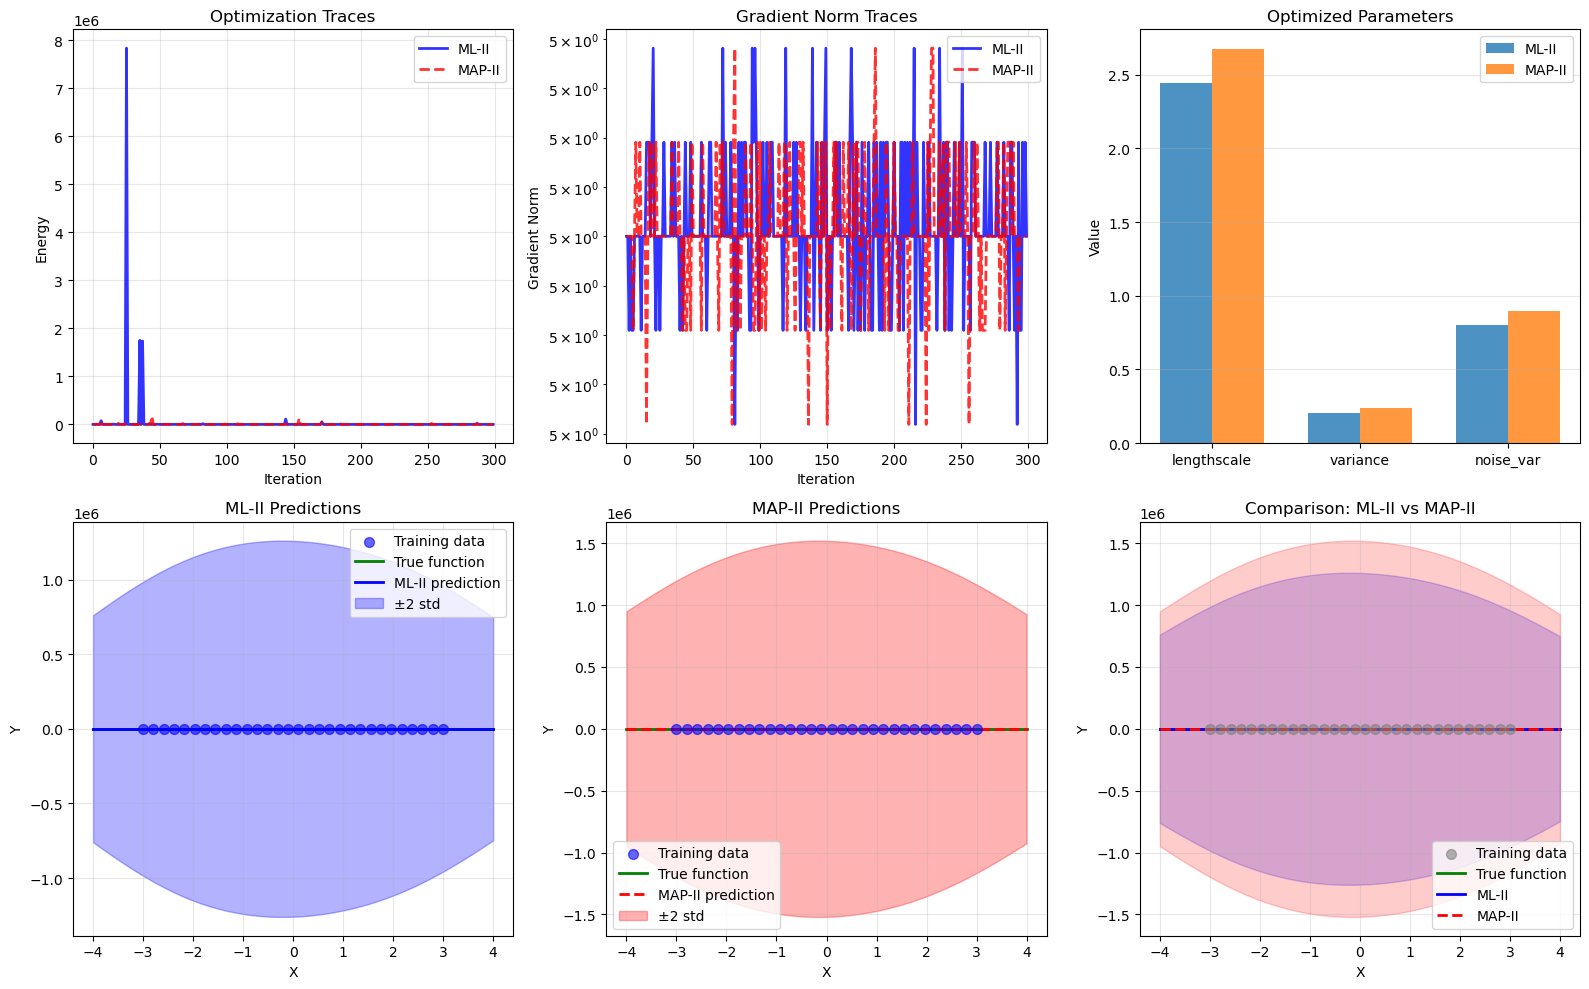

✅ Visualization complete!


In [10]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))

# 1. Optimization traces
ax1 = plt.subplot(2, 3, 1)
ax1.plot(energy_trace_ml2, 'b-', linewidth=2, label='ML-II', alpha=0.8)
ax1.plot(energy_trace_map2, 'r--', linewidth=2, label='MAP-II', alpha=0.8)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Energy')
ax1.set_title('Optimization Traces')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Gradient norms (if available)
ax2 = plt.subplot(2, 3, 2)
if hasattr(result_ml2, 'grad_norm_trace') and len(result_ml2.grad_norm_trace) > 0:
    ax2.plot(result_ml2.grad_norm_trace, 'b-', linewidth=2, label='ML-II', alpha=0.8)
if hasattr(result_map2, 'grad_norm_trace') and len(result_map2.grad_norm_trace) > 0:
    ax2.plot(result_map2.grad_norm_trace, 'r--', linewidth=2, label='MAP-II', alpha=0.8)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Gradient Norm')
ax2.set_title('Gradient Norm Traces')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Parameter comparison
ax3 = plt.subplot(2, 3, 3)
params_ml2 = [
    float(phi_ml2.kernel_params.lengthscale),
    float(phi_ml2.kernel_params.variance),
    float(phi_ml2.likelihood_params['noise_var']),
]
params_map2 = [
    float(phi_map2.kernel_params.lengthscale),
    float(phi_map2.kernel_params.variance),
    float(phi_map2.likelihood_params['noise_var']),
]
x_pos = np.arange(3)
width = 0.35
ax3.bar(x_pos - width/2, params_ml2, width, label='ML-II', alpha=0.8)
ax3.bar(x_pos + width/2, params_map2, width, label='MAP-II', alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['lengthscale', 'variance', 'noise_var'])
ax3.set_ylabel('Value')
ax3.set_title('Optimized Parameters')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Predictions: ML-II
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(X_train[:, 0], Y_train, c='blue', s=50, alpha=0.6, label='Training data', zorder=3)
ax4.plot(X_test[:, 0], f_test, 'g-', linewidth=2, label='True function', zorder=2)
ax4.plot(X_test[:, 0], mu_test_ml2, 'b-', linewidth=2, label='ML-II prediction', zorder=2)
ax4.fill_between(
    X_test[:, 0],
    mu_test_ml2 - 2 * std_test_ml2,
    mu_test_ml2 + 2 * std_test_ml2,
    alpha=0.3, color='blue', label='±2 std', zorder=1
)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_title('ML-II Predictions')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Predictions: MAP-II
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(X_train[:, 0], Y_train, c='blue', s=50, alpha=0.6, label='Training data', zorder=3)
ax5.plot(X_test[:, 0], f_test, 'g-', linewidth=2, label='True function', zorder=2)
ax5.plot(X_test[:, 0], mu_test_map2, 'r--', linewidth=2, label='MAP-II prediction', zorder=2)
ax5.fill_between(
    X_test[:, 0],
    mu_test_map2 - 2 * std_test_map2,
    mu_test_map2 + 2 * std_test_map2,
    alpha=0.3, color='red', label='±2 std', zorder=1
)
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_title('MAP-II Predictions')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Comparison: Both predictions together
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(X_train[:, 0], Y_train, c='gray', s=50, alpha=0.6, label='Training data', zorder=3)
ax6.plot(X_test[:, 0], f_test, 'g-', linewidth=2, label='True function', zorder=2)
ax6.plot(X_test[:, 0], mu_test_ml2, 'b-', linewidth=2, label='ML-II', zorder=2)
ax6.plot(X_test[:, 0], mu_test_map2, 'r--', linewidth=2, label='MAP-II', zorder=2)
ax6.fill_between(
    X_test[:, 0],
    mu_test_ml2 - 2 * std_test_ml2,
    mu_test_ml2 + 2 * std_test_ml2,
    alpha=0.2, color='blue', zorder=1
)
ax6.fill_between(
    X_test[:, 0],
    mu_test_map2 - 2 * std_test_map2,
    mu_test_map2 + 2 * std_test_map2,
    alpha=0.2, color='red', zorder=1
)
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_title('Comparison: ML-II vs MAP-II')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

In [11]:
print("\n" + "=" * 60)
print("Summary")
print("=" * 60)
print("\nThis notebook demonstrates:")
print("1. ML-II optimization: Optimizing InertialEnergy without hyperprior")
print("2. MAP-II optimization: Optimizing InertialEnergy with hyperprior")
print("3. Comprehensive metrics: MSE, RMSE, MAE, MAPE, R², Log-Likelihood")
print("4. Visualization: Optimization traces, predictions, and comparisons")
print("\nKey observations:")
print(f"- ML-II final energy: {energy_trace_ml2[-1]:.3f}")
print(f"- MAP-II final energy: {energy_trace_map2[-1]:.3f}")
print(f"- ML-II R²: {metrics_ml2['R²']:.4f}")
print(f"- MAP-II R²: {metrics_map2['R²']:.4f}")
print(f"- ML-II Log-Likelihood: {metrics_ml2['Log-Likelihood']:.4f}")
print(f"- MAP-II Log-Likelihood: {metrics_map2['Log-Likelihood']:.4f}")


Summary

This notebook demonstrates:
1. ML-II optimization: Optimizing InertialEnergy without hyperprior
2. MAP-II optimization: Optimizing InertialEnergy with hyperprior
3. Comprehensive metrics: MSE, RMSE, MAE, MAPE, R², Log-Likelihood
4. Visualization: Optimization traces, predictions, and comparisons

Key observations:
- ML-II final energy: 160.335
- MAP-II final energy: 65.910
- ML-II R²: 0.0000
- MAP-II R²: 0.0000
- ML-II Log-Likelihood: -1411.3116
- MAP-II Log-Likelihood: -1430.6284
